In [1]:
# mount your cloud based google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
#
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/photo_jpg/4707b03a08.jpg
/content/drive/MyDrive/photo_jpg/5f02c26178.jpg
/content/drive/MyDrive/photo_jpg/76ef022161.jpg
/content/drive/MyDrive/photo_jpg/403a9eb385.jpg
/content/drive/MyDrive/photo_jpg/569ed795ec.jpg
/content/drive/MyDrive/photo_jpg/65a09899f8.jpg
/content/drive/MyDrive/photo_jpg/394a38353e.jpg
/content/drive/MyDrive/photo_jpg/098b35d919.jpg
/content/drive/MyDrive/photo_jpg/11068aa40b.jpg
/content/drive/MyDrive/photo_jpg/69e5be6684.jpg
/content/drive/MyDrive/photo_jpg/418d1c582c.jpg
/content/drive/MyDrive/photo_jpg/271ec1348b.jpg
/content/drive/MyDrive/photo_jpg/19e7940d94.jpg
/content/drive/MyDrive/photo_jpg/1cc26c48b8.jpg
/content/drive/MyDrive/photo_jpg/2b7402e62d.jpg
/content/drive/MyDrive/photo_jpg/31dd6a20fc.jpg
/content/drive/MyDrive/photo_jpg/303b61552d.jpg
/content/drive/MyDrive/photo_jpg/4c1907f1a0.jpg
/content/drive/MyDrive/photo_jpg/355475c717.jpg
/content/drive/MyDrive/photo_jpg/091b

---------------------------------------
# Introduction

**Neural Style Transfer**

> Neural Style Transfer (NST) refers to a class of software algorithms that manipulate digital images, or videos, in order to adopt the appearance or visual style of another image. NST algorithms are characterized by their use of deep neural networks for the sake of image transformation. Common uses for NST are the creation of artificial artwork from photographs, for example by transferring the appearance of famous paintings to user-supplied photographs. Several notable mobile apps use NST techniques for this purpose, including DeepArt and Prisma. This method has been used by artists and designers around the globe to develop new artwork based on existent style(s).

Ref: https://en.wikipedia.org/wiki/Neural_Style_Transfer

Style transfer means that when a content image and a style image are given, the outline and shape of the image are similar to the content image, and the color or texture is changed to be similar to the style image.

By separating content and style, you can mix content and style of different images.


A pre-trained VGG19 Net is used as a model to extract content and style. It then uses the losses of the content and style to iteratively update the target image until the desired result is achieved.

In [3]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

------------------------------------------------
# 1. Load in model --- use pre-trained VGG19 model

VGG19 is divided into two parts.

* vgg19.features: All convolutional layers and pooling layers
* vgg19.classifier: The last three linear layers are the classifier layer.

We only need the features part. And "freeze" so that the weight is not updated.

In [4]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:01<00:00, 395MB/s]


In [5]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

-----------------------------------------------
# 2. Load in Content and Style Images

Load the content image and style image to be used for style transfer. The load_image function transforms the image and loads it in the form of normalized Tensors.



In [6]:
def load_image(img_path, max_size=128, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

Load the content image and style image.

In [7]:
# load in content and style image
#content = load_image('/kaggle/input/images-for-style-transfer/Data/Artworks/856047.jpg').to(device)
# Resize style to match content, makes code easier
#style = load_image('/kaggle/input/neural-style-transfer/Style Images/starry_night.jpg').to(device)
# Load in content and style image
content = load_image('/content/drive/MyDrive/856047.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/drive/MyDrive/starry_night.jpg').to(device)

In [8]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

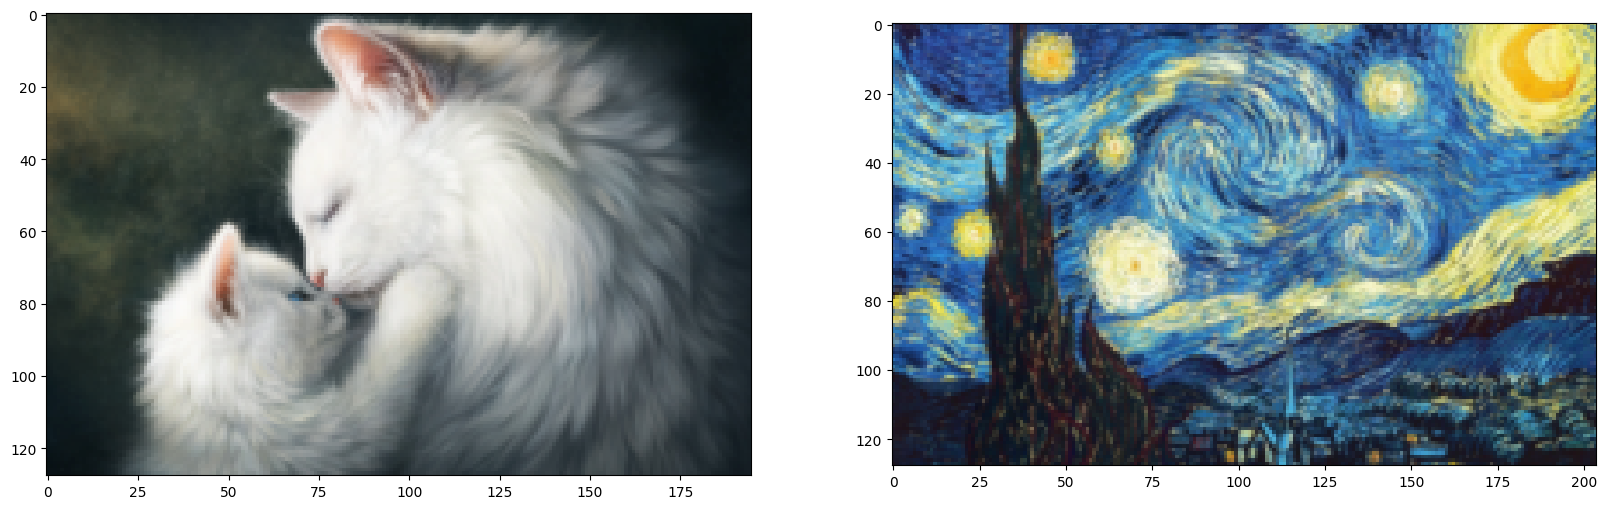

In [9]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [10]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

--------------------------------------------------
# 3. Gram Matrix

![](https://miro.medium.com/max/1400/1*VAQs1KSfbysnloPah_fHGQ.gif)

Picture Credit: https://miro.medium.com


> The matrix expressing the correlation of this Channel is called Gram Matrix. Loss is minimized by defining the difference between this Gram Matrix and the Gram Matrix of the newly created image as a Loss Function. Next, in order to reflect the content, the loss function is calculated in units of pixels from the feature map spit out from each pre-trained CNN. In this way, a new image is created that minimizes the Loss calculated from Style and Loss calculated from Content.

https://en.wikipedia.org/wiki/Gram_matrix


In [11]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
    """

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

The function that extracts the features of a given convolutional layer and computes the Gram Matrix is made. Putting it all together, we extract the features from the image and compute the Gram Matrix for each layer from the style representation.

In [12]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---------------------------------------------
# 4. Define Losses and Weights

**Individual Layer Style Weights**

You can give the option to weight the style expression in each relevant layer. It is recommended that the layer weight range from 0 to 1. By giving more weight to conv1_1 and conv2_1, more style artifacts can be reflected in the final target image.

**Content and Style Weight**

Define alpha (content_weight) and beta (style_weight). This ratio affects the style of the final image. It is recommended to leave content_weight = 1 and set style_weight to achieve the desired ratio.

In [13]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e3  # beta

# 5. Update Target and Calculate Losses

**Content Loss**

The content loss is calculated as the MSE between the target and the content feature in the 'conv4_2' layer.

**Style Loss**

The style loss is the loss between the target image and the style image. That is, it refers to the difference between the gram matrix of the style image and the gram matrix of the target image. Loss is calculated using MSE

**Total Loss**

Finally, the total loss is calculated by summing the style and content losses and weighting them with the specified alpha and beta.

Total loss:  3891.165771484375


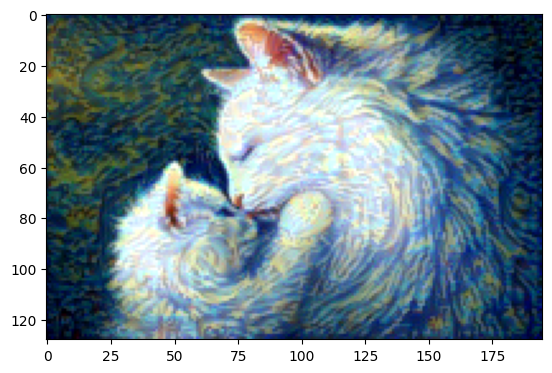

Total loss:  1579.6729736328125


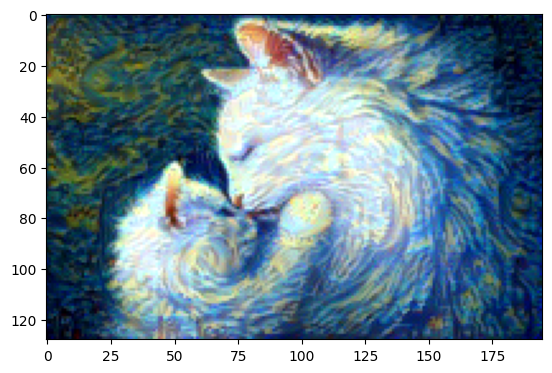

Total loss:  1112.0819091796875


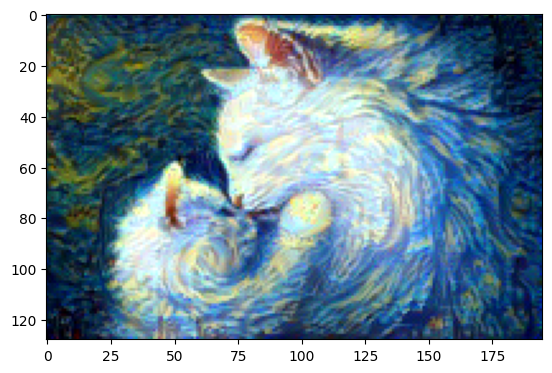

Total loss:  844.5445556640625


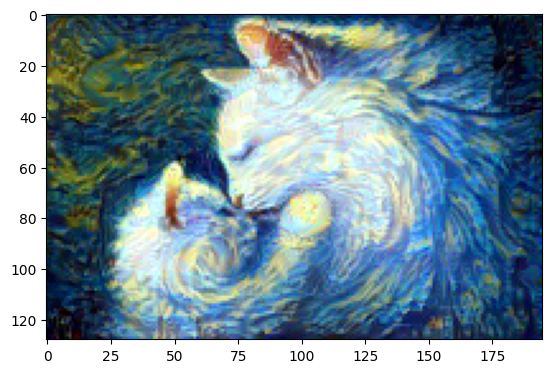

Total loss:  673.57177734375


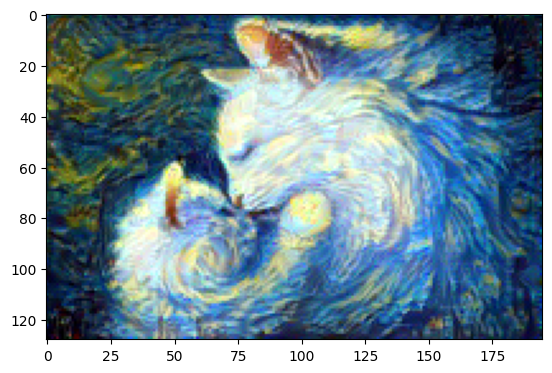

Total loss:  556.8540649414062


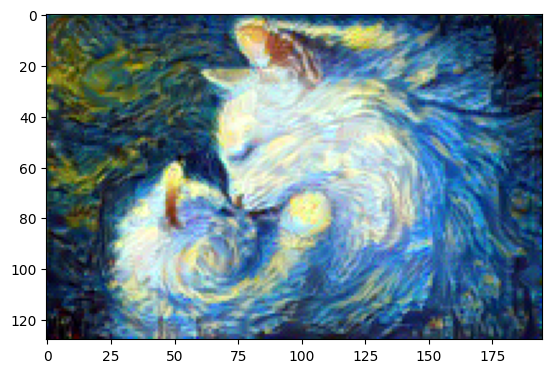

Total loss:  475.3677062988281


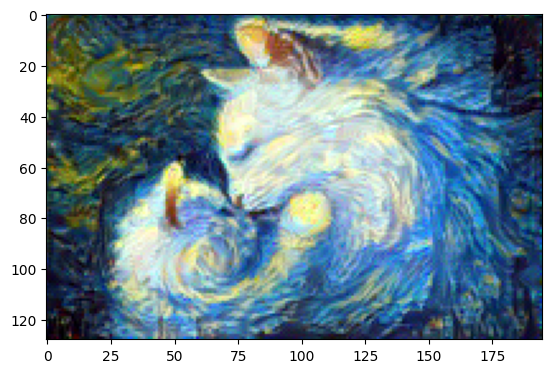

Total loss:  417.77301025390625


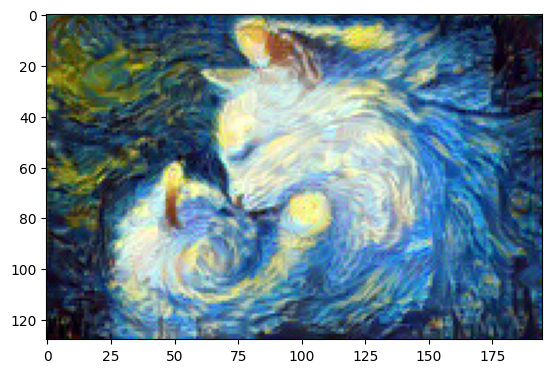

Total loss:  374.4173278808594


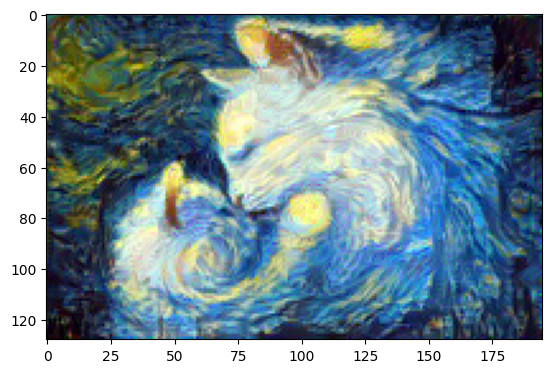

Total loss:  340.0111389160156


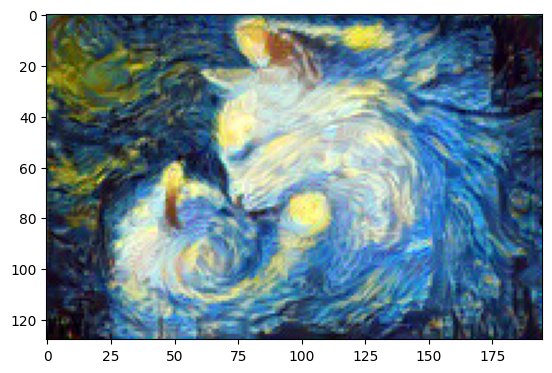

In [14]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5001  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

-----------------------------------------------------------------
# 6. Check the last result

In [15]:
# display content and final, target image
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#ax1.imshow(im_convert(content))
#ax2.imshow(im_convert(target))

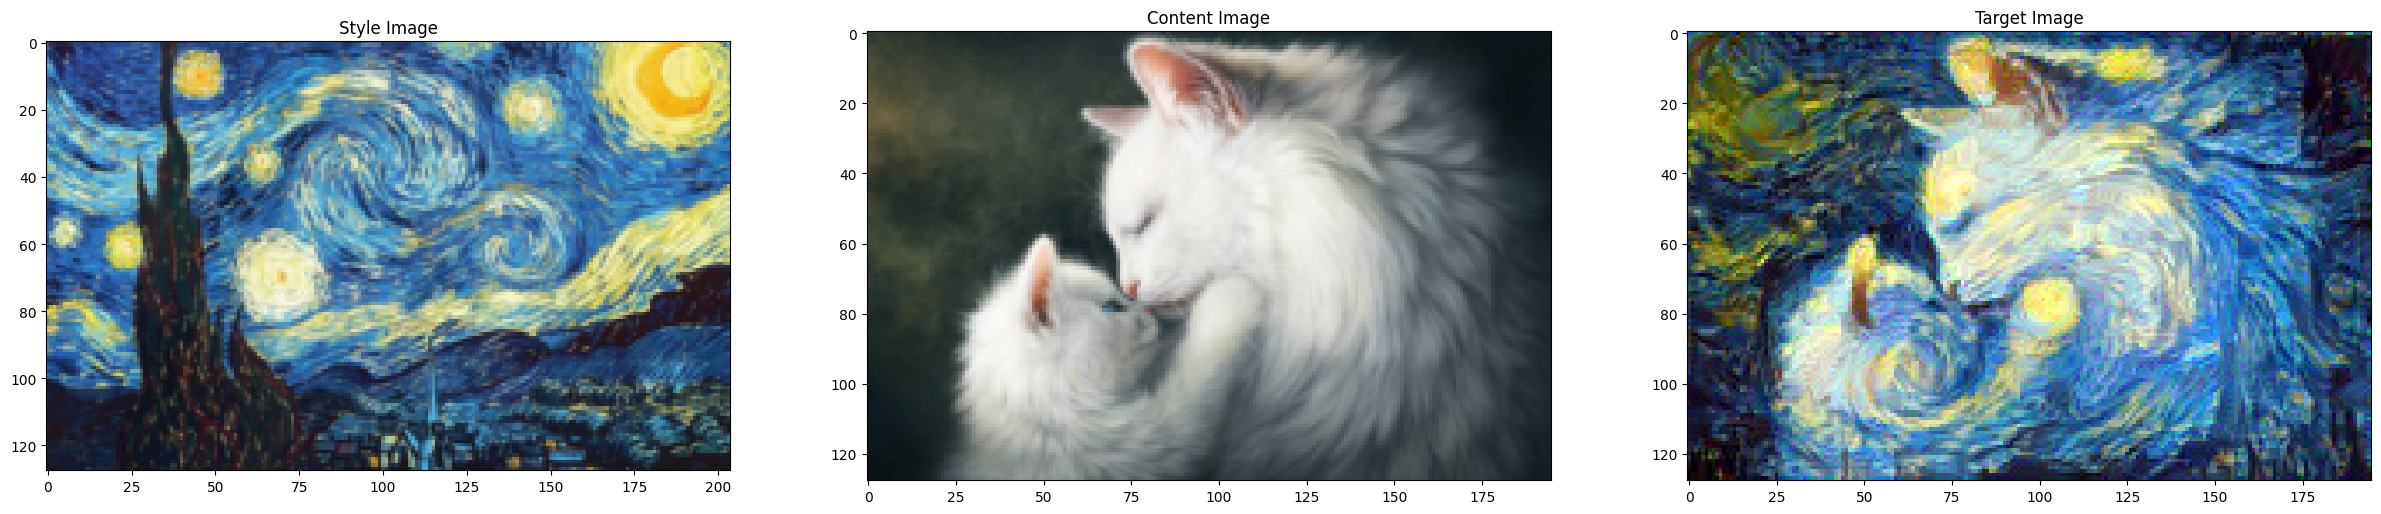

In [16]:
# Import matplotlib if not already imported
import matplotlib.pyplot as plt

# Function to convert images may look something like 'im_convert'. Make sure it's defined.

# Create a figure with 1 row and 3 columns, setting the figure size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

# Display the style, content, and target images
ax1.imshow(im_convert(style))
ax2.imshow(im_convert(content))
ax3.imshow(im_convert(target))

# Add titles to the plots
ax1.set_title('Style Image')
ax2.set_title('Content Image')
ax3.set_title('Target Image')

# Show the plot
plt.show()


## Using ResNet Models (ResNet-50, ResNet-101):
##### ResNet-50 used below:
 These are also useful for style transfer, although they are more computationally intensive. They capture complex features and are often used for high-resolution style transfer. However, their deeper architectures can sometimes be harder to work with for style transfer specifically.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 306MB/s]


Step [0/500], Content Loss: 0.0, Style Loss: 6900010.5
Step [50/500], Content Loss: 0.594013512134552, Style Loss: 19884.84765625
Step [100/500], Content Loss: 0.5797025561332703, Style Loss: 5771.94287109375
Step [150/500], Content Loss: 0.5790393352508545, Style Loss: 2883.239501953125
Step [200/500], Content Loss: 0.5926823019981384, Style Loss: 1495.8040771484375
Step [250/500], Content Loss: 0.6055834293365479, Style Loss: 810.4751586914062
Step [300/500], Content Loss: 0.6145750284194946, Style Loss: 476.60394287109375
Step [350/500], Content Loss: 0.6232277154922485, Style Loss: 308.53521728515625
Step [400/500], Content Loss: 0.6268975138664246, Style Loss: 217.84405517578125
Step [450/500], Content Loss: 0.6311759352684021, Style Loss: 164.90650939941406
Content Image


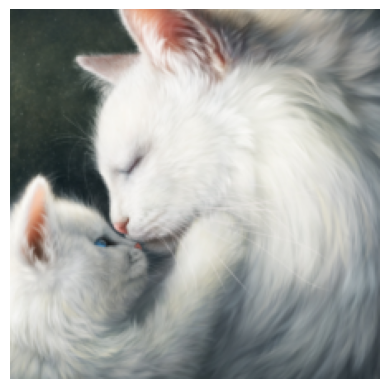

Style Image


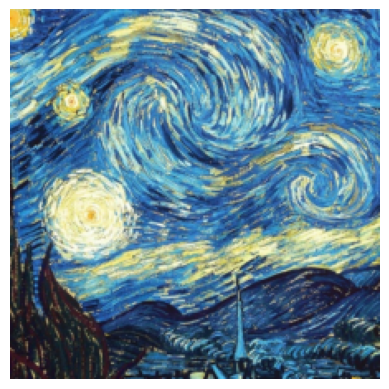

Generated Image


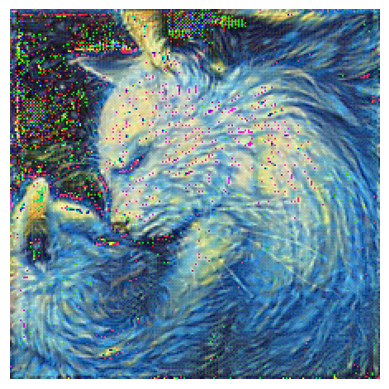

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define preprocessing pipeline
preprocessor = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load and preprocess the images
#content_img = Image.open("/content/856047.jpg")
#style_img = Image.open("/content/starry_night.jpg")
content_img = Image.open('/content/drive/MyDrive/856047.jpg')
style_img = Image.open('/content/drive/MyDrive/starry_night.jpg')
content_tensor = preprocessor(content_img).unsqueeze(0)
style_tensor = preprocessor(style_img).unsqueeze(0)

# Load pretrained ResNet-50 model + higher level layers
model = models.resnet50(pretrained=True)
layers = list(model.children())[:-2]  # remove the classification head

# Create custom forward method to get activations at desired layers
def forward(x, layers):
    activations = []
    for layer in layers:
        x = layer(x)
        activations.append(x)
    return activations[-1], activations  # Return final output and intermediate activations

# Extract features from content and style image
with torch.no_grad():
    content_features, _ = forward(content_tensor, layers)
    _, style_features = forward(style_tensor, layers)

# Initialize generated image to content image
generated_img = content_tensor.clone().requires_grad_(True)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam([generated_img], lr=0.1)

# Training loop, CHANGE PARAMETERS HERE!
num_steps = 500
style_weight = 1e2  # Weight for style loss
content_weight = 1  # Weight for content loss

for step in range(num_steps):
    # Obtain the features of the generated image
    gen_features, gen_activations = forward(generated_img, layers)

    # Content loss
    content_loss = criterion(gen_features, content_features)

    # Style loss
    style_loss = 0
    for f1, f2 in zip(gen_activations, style_features):
        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)
        f2 = f2.view(c, h * w)
        gram_f1 = torch.mm(f1, f1.t())
        gram_f2 = torch.mm(f2, f2.t())
        style_loss += criterion(gram_f1, gram_f2)

    # Total loss
    loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f'Step [{step}/{num_steps}], Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}')

# Display images
def imshow(tensor):
    image = tensor.clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

print("Content Image")
imshow(content_tensor)
print("Style Image")
imshow(style_tensor)
print("Generated Image")
imshow(generated_img)


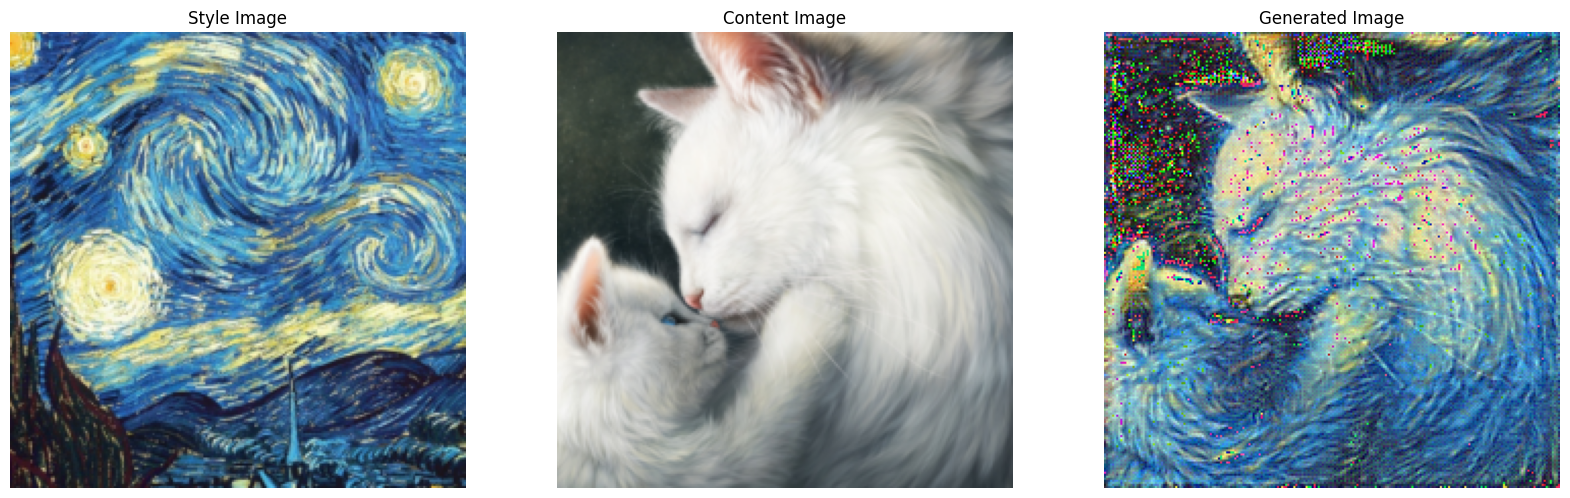

In [18]:
# Function to convert a tensor to a PIL Image
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

# Convert tensors to PIL Images
content_PIL = tensor_to_PIL(content_tensor)
style_PIL = tensor_to_PIL(style_tensor)
generated_PIL = tensor_to_PIL(generated_img.detach())

# Display images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Style Image
ax1.imshow(style_PIL)
ax1.set_title('Style Image')
ax1.axis('off')

# Content Image
ax2.imshow(content_PIL)
ax2.set_title('Content Image')
ax2.axis('off')


# Generated Image
ax3.imshow(generated_PIL)
ax3.set_title('Generated Image')
ax3.axis('off')

plt.show()